In [1]:
import os
import warnings
from datetime import datetime

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import vaex as vx
from data_struct import dtypes
from dateutil import parser
from matplotlib import dates as mpl_dates
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from tensorflow.keras.layers import LSTM, Dense, Flatten
# univariate lstm example
from tensorflow.keras.models import Sequential

warnings.filterwarnings('ignore')

%matplotlib widget
%load_ext line_profiler


In [2]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})
plt.style.use('dark_background')


In [3]:
path = os.getcwd()
# Imports data
parse_dates = ['Sale Date', 'Sale Day', 'Sale Date Local']

#custom_dates = lambda x: parser.parse(x) or pd.to_datetime
#You can try both to check speed of import
try:
    data = vx.open('%s//Data//consumption_data.csv.hdf5'%path)
except (FileNotFoundError):
    data = vx.from_csv('%s//Data//consumption_data.csv'%path, 
                       dtype=dtypes, parse_dates=parse_dates, date_parser=pd.to_datetime,
            chunk_size=100_000, convert=True)


# Place all Column Names in a List
col_names = data.get_column_names()
# Renaming all columns to fit Vaex standards
for i in col_names:
    new_name = i.replace(" ", "_").replace("-","_")
    data.rename(i, new_name)
    col_names[col_names.index(i)] = new_name



In [4]:
# Filtering Data to relevant Columns
df = data.copy()[[col_names[2], col_names[4], col_names[5], col_names[6], 
                col_names[9], col_names[10], col_names[11], col_names[12], col_names[13],
                col_names[14], col_names[15],col_names[41], col_names[43], col_names[44], col_names[50]]]

df.get_column_names()

['Sale_Date',
 'Sale_Facility_Country',
 'Sale_Day',
 'Sale_Facility',
 'Customer_Type',
 'Vdl_Drug_ID',
 'Vdl_Drug_Display_Name',
 'Unit_Selling_Price_Local',
 'Unit_Selling_Price_Usd',
 'Quantity_In_Units',
 'Quantity_In_Packs',
 'Sale_Date_Local',
 'Item_Sub_Category',
 'Insurance_Pay_Or',
 'How_Its_Sold']

In [5]:
facility_names = [f"Facility_{x}" for x in range(len(df['Sale_Facility'].unique()))]
facility_dict = {}

for old_name, new_name in zip(df['Sale_Facility'].unique(), facility_names):
    facility_dict[old_name] = new_name

df['Sale_Facility'] = df['Sale_Facility'].apply(lambda x: facility_dict[x]).values

#Dropping Redundant Facilities
df = df[~df['Sale_Facility'].isin(['Facility_38', 'Facility_25'])] 


In [6]:
df.info()

**ANALYSES PER FACILITY**

In [7]:
#For mock purposes we will go with the facility with the highest number of rows

count = 0
for facility in df['Sale_Facility'].unique():
    if len(df[df['Sale_Facility']==facility]) > count:
        count = len(df[df['Sale_Facility']==facility])
        largest = facility

print(f"{largest} is the largest facility in terms of volume of transactions with  {count} transactions")


Facility_0 is the largest facility in terms of volume of transactions with  53037 transactions


In [8]:
#Using the same idea to get the Item with the highest volume of transactions on
fty_df = df[df['Sale_Facility'] == largest]

count = 0
for item_class in df['Item_Sub_Category'].unique():
    if len(df[df['Item_Sub_Category'] == item_class]) > count:
        count = len(df[df['Item_Sub_Category'] == item_class])
        largest = item_class

print(f"{largest} are sold more often with {count} volume of transactions")


Analgesics are sold more often with 124658 volume of transactions


In [9]:
#Since no data represents medications with no class intuitive conclusions cant be draw with regards to class.
#Lets go with Anti-Infectives instead

con_df = fty_df[fty_df['Item_Sub_Category'] == largest]

In [10]:
#Split the data into the respective Date Frequencies eg. Yearly, Monthly, Weekly, Daily, Hourly
#We are using quantity in Units because you can derive the pack size from it

freq_dict = {}
for i in zip(['W', 'M'], ['weekly', 'monthly']):
    freq_dict[i[1]] = con_df.groupby(by=vx.BinnerTime(con_df['Sale_Date'], resolution=i[0]), agg={'Quantity_In_Units':'sum'})


 ### PREPROCESSING AND VISUALIZATION

In [11]:
#Develop in house function for rolling means/std since vaex has no inbuilt function for this

def rolling_window(a, window, find_mean, find_std):
    old_shape = a.shape[0]
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    view = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    
    if find_mean:
        final = np.array([view[i,:].mean() for i in range(view.shape[0])])
        
    elif find_std:
        final = np.array([view[i,:].std() for i in range(view.shape[0])])
        
    new_shape = view.shape[0]
    zeros = np.array([0 for x in range(old_shape - new_shape)])
    result = np.concatenate((zeros,final))
    return result

In [12]:
#Build function for plots to showcase the rolling window and SavGol

def plots(x, y, title, window=3, ylabel='Quantity Sold in Units', mean=False, std=False, sav=False):
    date="%b, %d %Y"
    xlabel='Date'
    
    fig = plt.figure()
    plt.plot_date(x, y, linestyle='solid', marker=None, fmt='c', label='Main Time Series Data')
    if sav:
        plt.plot_date(x, savgol_filter(y,window,3),
                      linestyle='solid', marker=None, fmt='y', label='Saviztky Golay Algo with Window Size of %s'%window)
    if mean:
        plt.plot_date(x, rolling_window(y,window=window,find_mean=True,find_std=False),
                      linestyle='solid', marker=None, fmt='r', label='Moving Average with Window Size of %s'%window)
    if std:
        plt.plot_date(x, rolling_window(y,window=window,find_std=True, find_mean=False),
                      linestyle='solid', marker=None, fmt='b', label='Moving Std with Window Size of %s'%window)
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter(date)
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
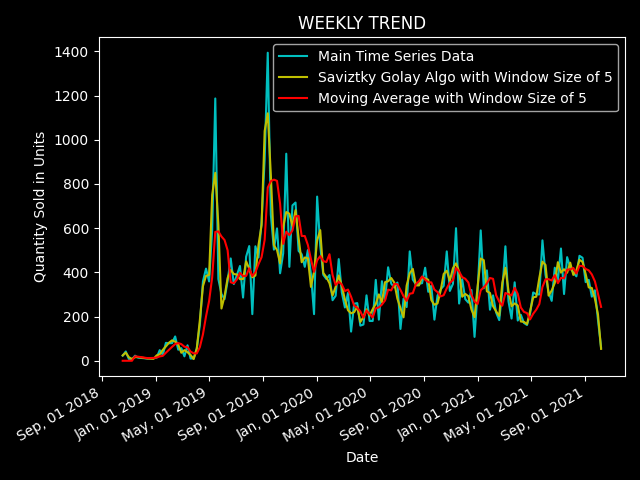

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
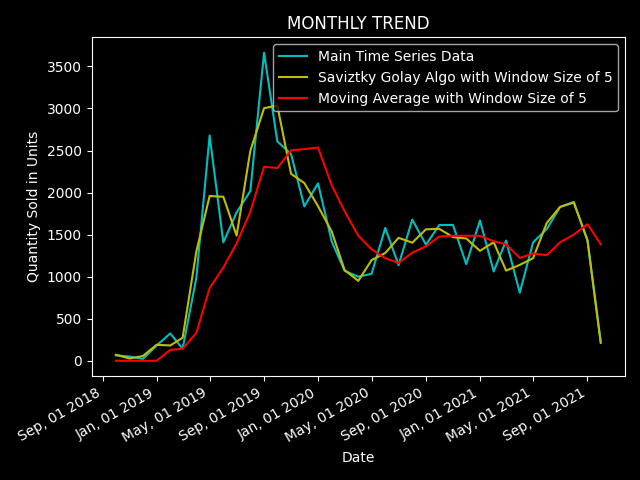

In [13]:
windows = [16, 12]

for freq in freq_dict.keys():
    plots(freq_dict[freq]['Sale_Date'].values, freq_dict[freq]['Quantity_In_Units'].values,
          f'{freq} Trend'.upper(),5, mean=True, sav=True)

### **Stationarity Check With ADF Test**

WEEKLY Data is Stationary. Proceed to Modelling
Results of Dickey Fuller Test for WEEKLY Data 
P-value       0.012801
#lags used    2.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
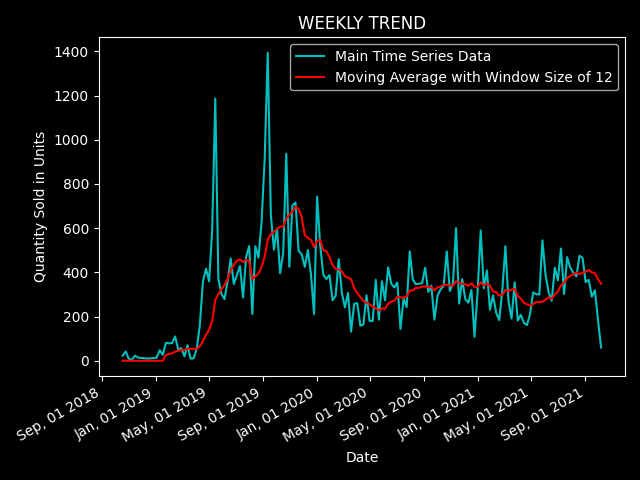

MONTHLY Data is not Stationary. More Preprocessing Required
Results of Dickey Fuller Test for MONTHLY Data 
P-value       0.384862
#lags used    7.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
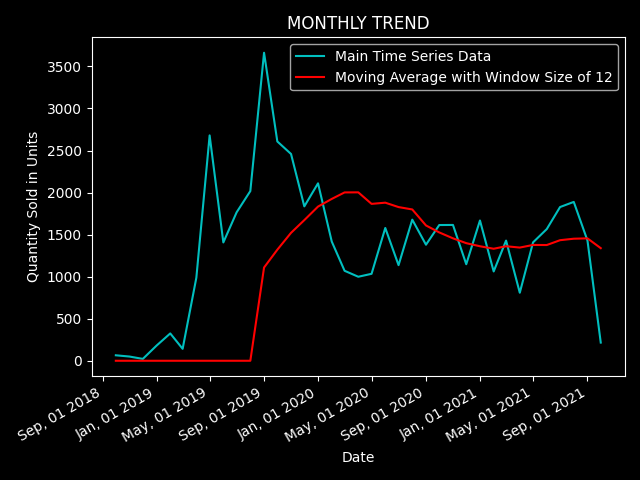

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
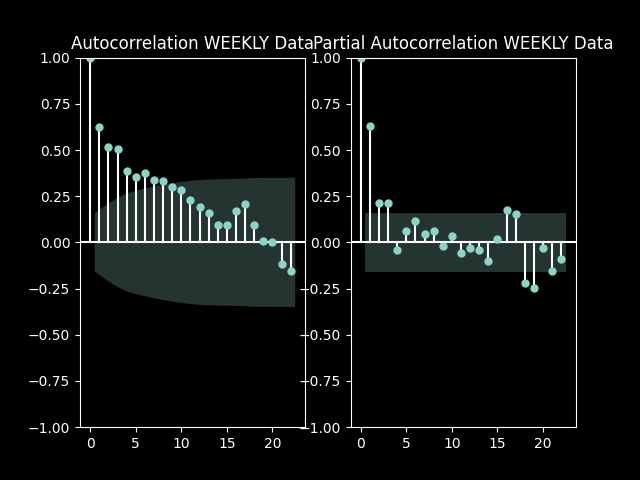

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
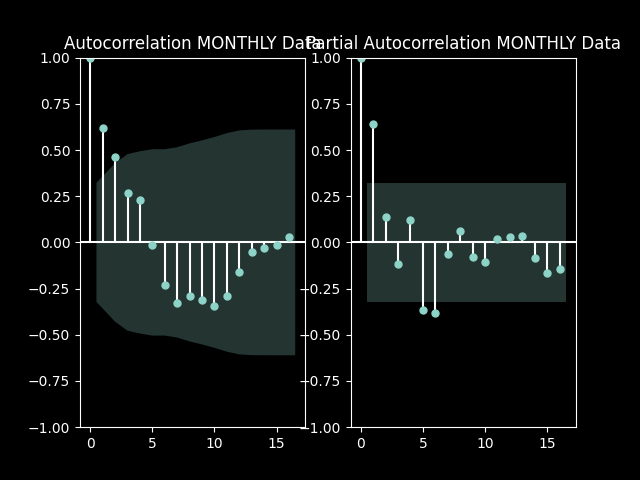

In [14]:
# Adfuller Test to Check for Stationary Datasets
def stat_check(data, ts, dates):
    test = adfuller(data, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic', 'P-value', '#lags used', 'Number of Observations Used'])
    
    for key,value in test[4].items():
        results['Critical Value (%s)'%key] = value
    if results[1] <= 0.05:
        print(f'{ts} Data is Stationary. Proceed to Modelling')
    else:
        print(f'{ts} Data is not Stationary. More Preprocessing Required')
    print(f'Results of Dickey Fuller Test for {ts} Data \n{results[1:3]}')
    
    # Original Series
    
    plots(dates, data, f'{freq} Trend'.upper(), 12, mean=True)
    
    # Autocorrelation Plot
    fig, (ax1, ax2) = plt.subplots(1,2)
    plot_acf(data, ax=ax1, title=f'Autocorrelation {ts} Data')
    # Partial Autocorrelation Plot
    plot_pacf(data, ax=ax2, title=f'Partial Autocorrelation {ts} Data')


for freq in freq_dict.keys():
    stat_check(data=freq_dict[freq]['Quantity_In_Units'].values, ts=freq.upper(), dates=freq_dict[freq]['Sale_Date'].values)



### **1. Seasonal Decomposition to Ensure Stationarity**

In [15]:
# One means of ensuring stationarity is decomposing and taking the residuals
def decompose(data, t_series, period, title, show_plot=True):
    result = seasonal_decompose(data, period=12)
    if show_plot:
        plots(t_series, result.trend, f'{title} Data Trend')
        plots(t_series, result.seasonal, f'{title} Data Seasonality')
        plots(t_series, result.resid, f'{title} Data Residuals')
    return np.nan_to_num(result.resid, 0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
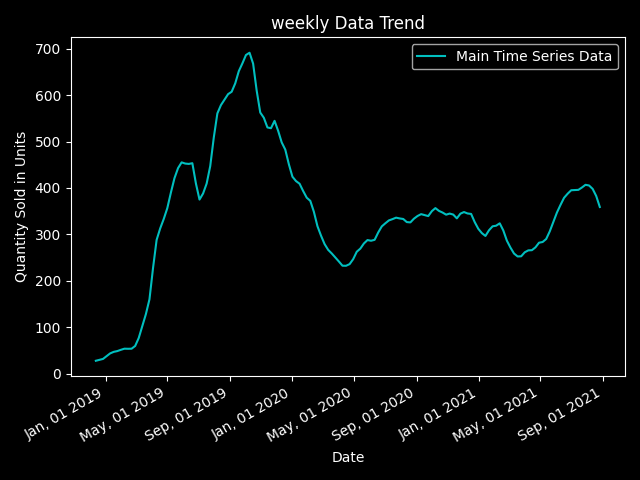

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
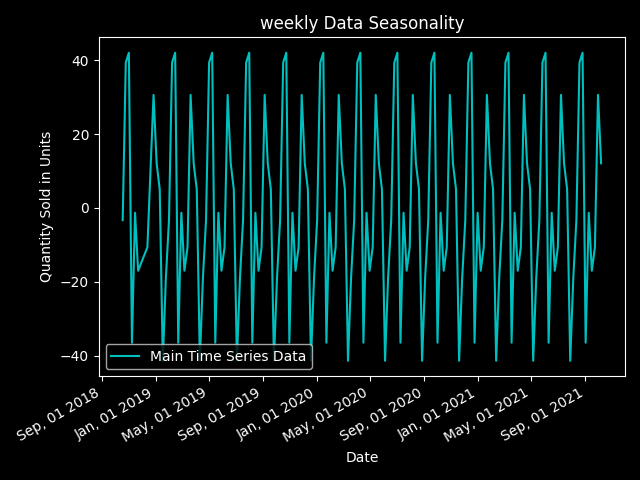

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
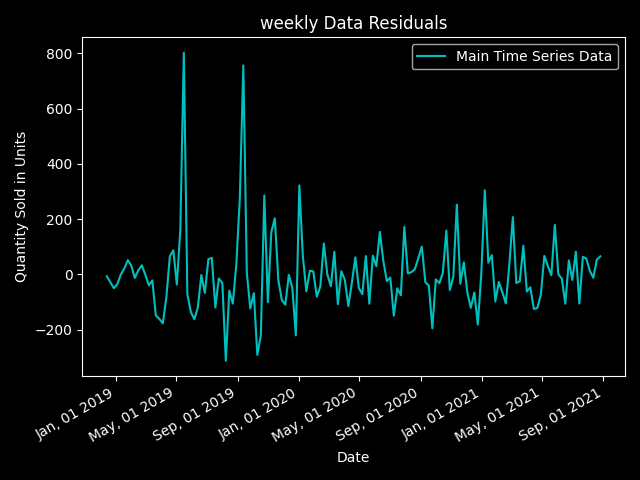

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
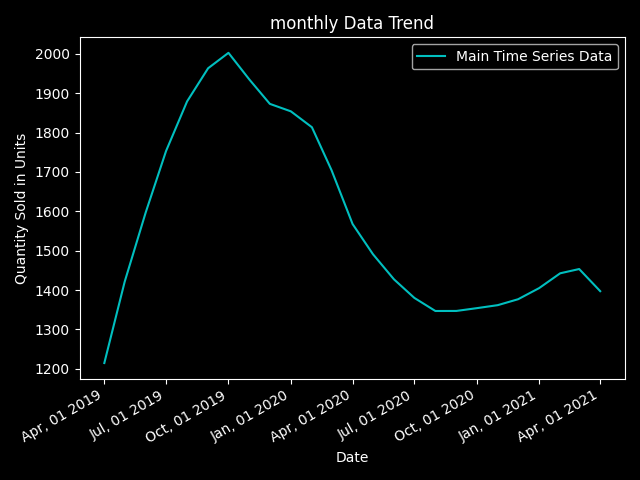

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
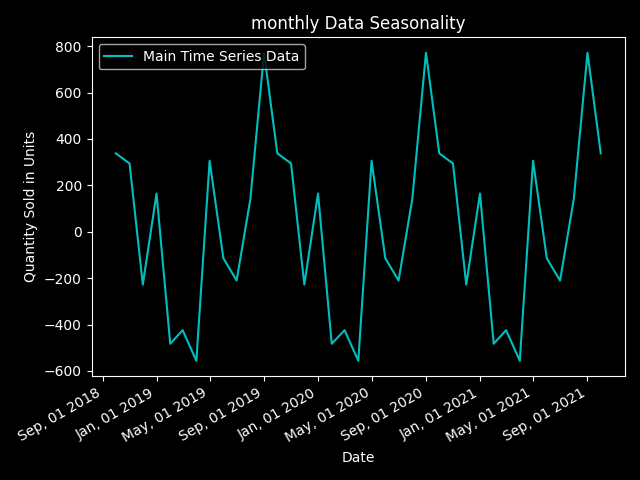

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
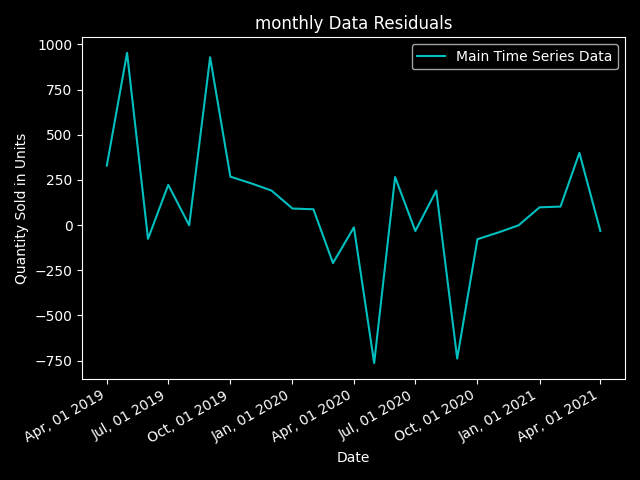

In [16]:
for freq in freq_dict.keys():
    residuals = decompose(freq_dict[freq]['Quantity_In_Units'].values,
                              freq_dict[freq]['Sale_Date'].values, title=freq, period=12)
    freq_dict[freq]['residuals'] = residuals


WEEKLY Data is Stationary. Proceed to Modelling
Results of Dickey Fuller Test for WEEKLY Data 
P-value       8.759783e-09
#lags used    1.400000e+01
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
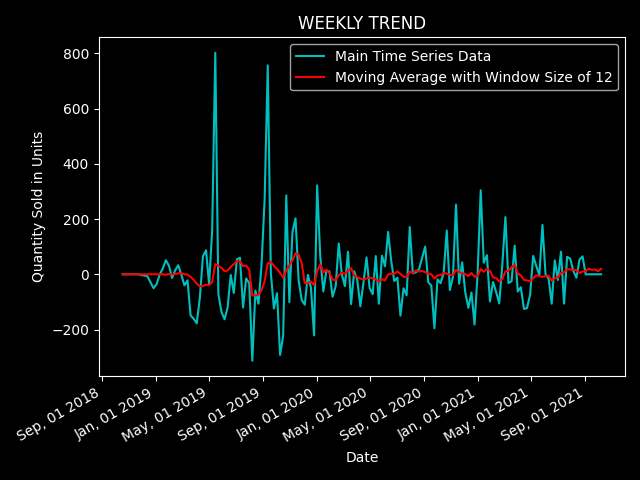

MONTHLY Data is not Stationary. More Preprocessing Required
Results of Dickey Fuller Test for MONTHLY Data 
P-value       0.166507
#lags used    7.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
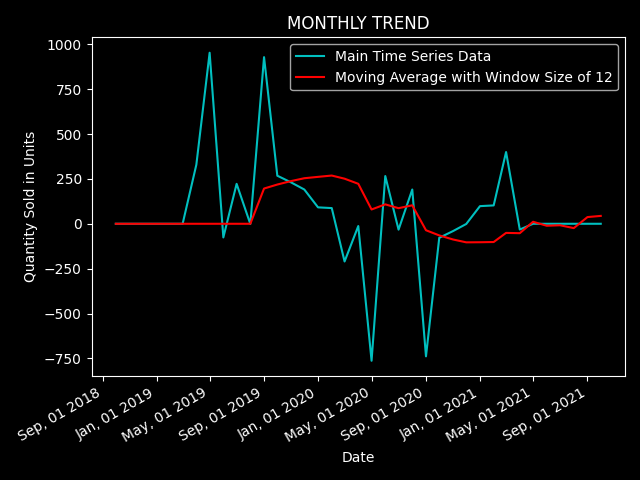

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
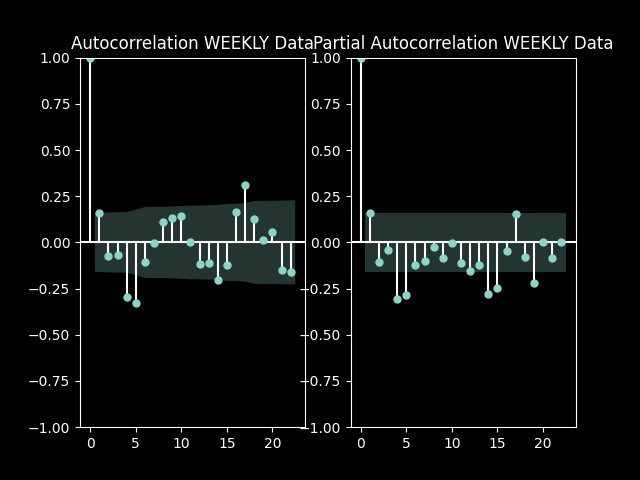

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
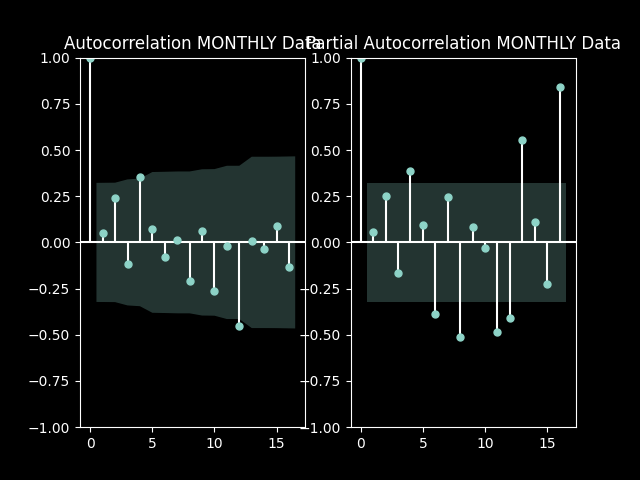

In [17]:
for freq in freq_dict.keys():
    stat_check(data=freq_dict[freq]['residuals'].values, ts=freq.upper(), dates=freq_dict[freq]['Sale_Date'].values)

### **2. Log of the Values**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
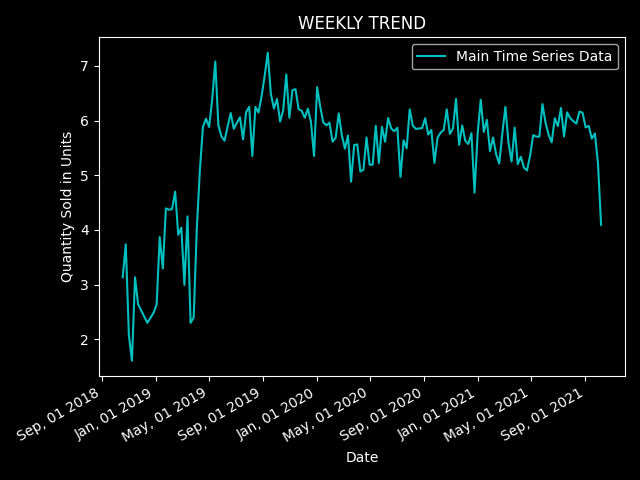

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
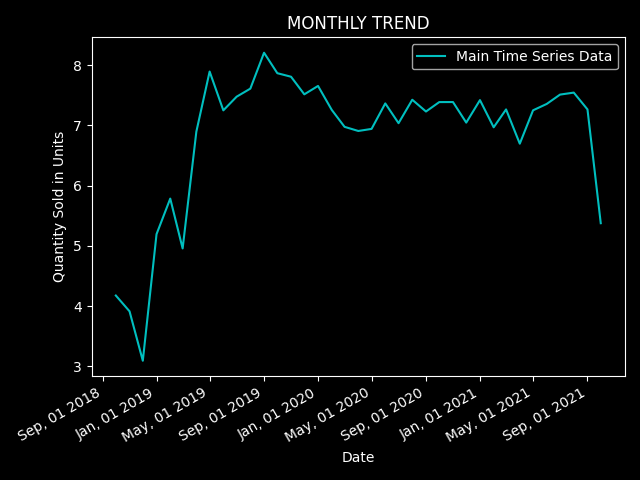

In [18]:
for freq in freq_dict.keys():
    freq_dict[freq]['log'] = freq_dict[freq]['Quantity_In_Units'].apply(lambda x: np.log(x))

for freq in zip(freq_dict.keys(), [24, 7, 4, 12]):
    plots(freq_dict[freq[0]]['Sale_Date'].values, freq_dict[freq[0]]['log'].values,
          f'{freq[0]} Trend'.upper(), freq[1])

WEEKLY Data is Stationary. Proceed to Modelling
Results of Dickey Fuller Test for WEEKLY Data 
P-value       0.001768
#lags used    8.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
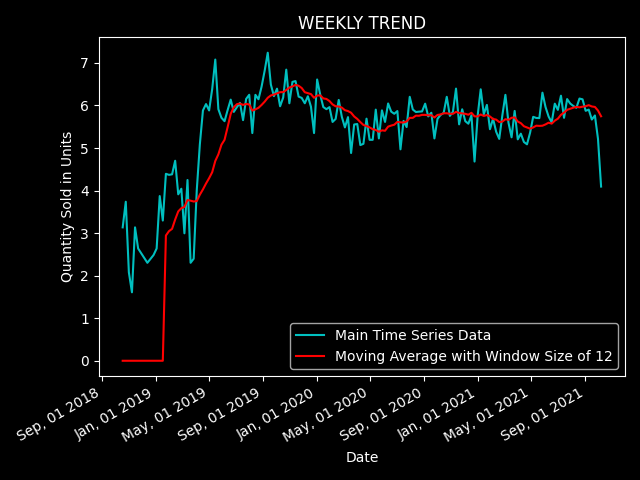

MONTHLY Data is not Stationary. More Preprocessing Required
Results of Dickey Fuller Test for MONTHLY Data 
P-value       0.123434
#lags used    0.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
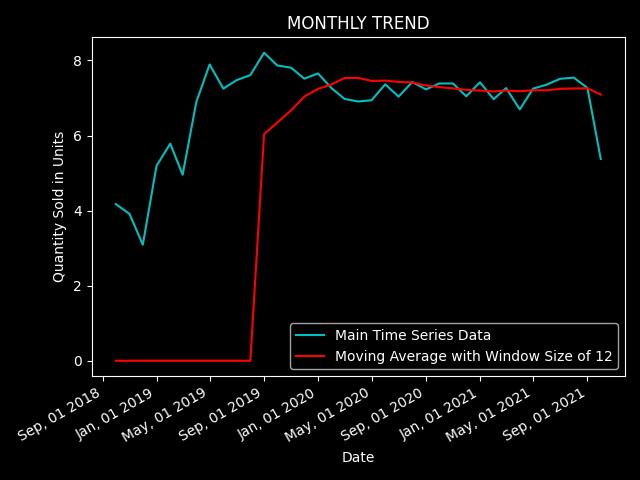

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
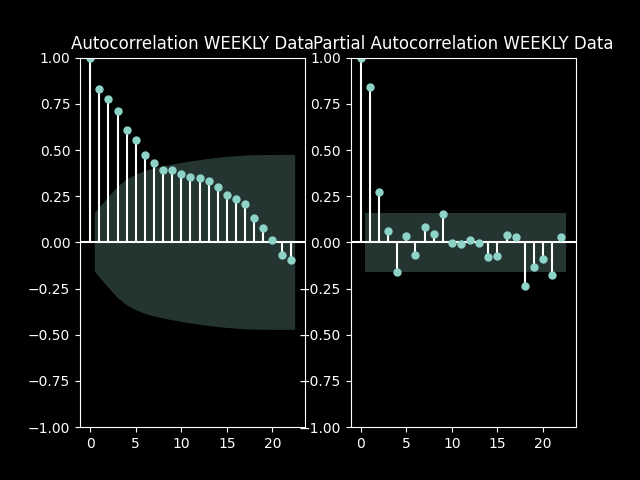

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
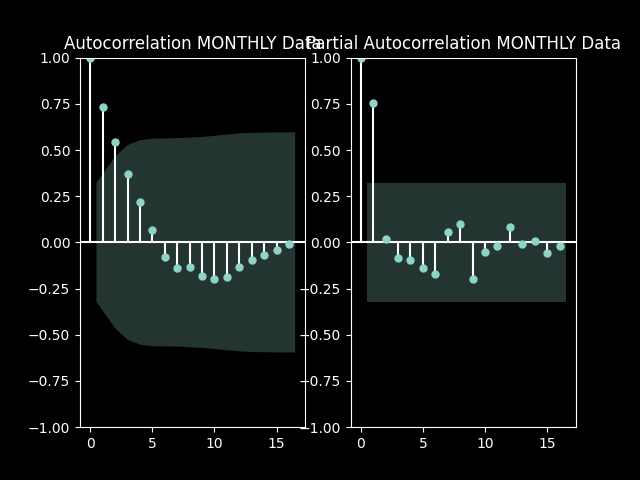

In [19]:
for freq in freq_dict.keys():
    stat_check(data=freq_dict[freq]['log'].values, ts=freq.upper(), dates=freq_dict[freq]['Sale_Date'].values)

### 3. **Subtracting Rolling Mean**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
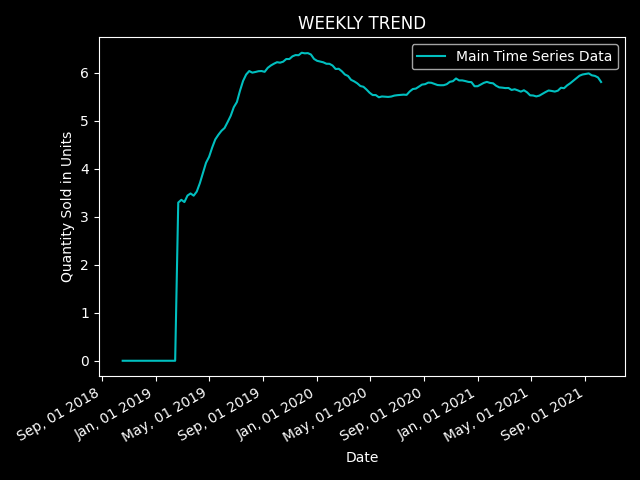

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
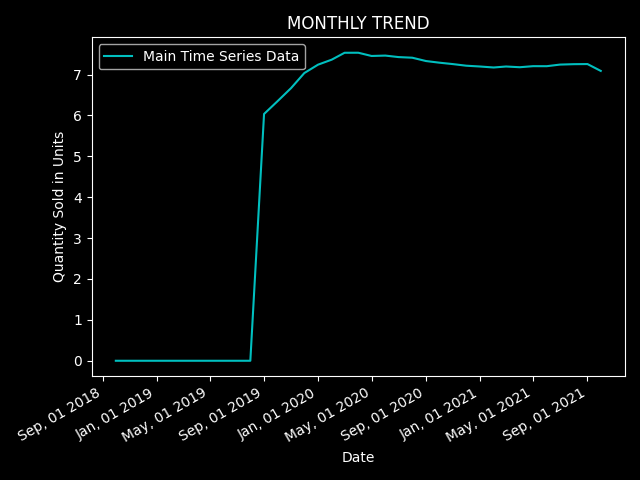

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
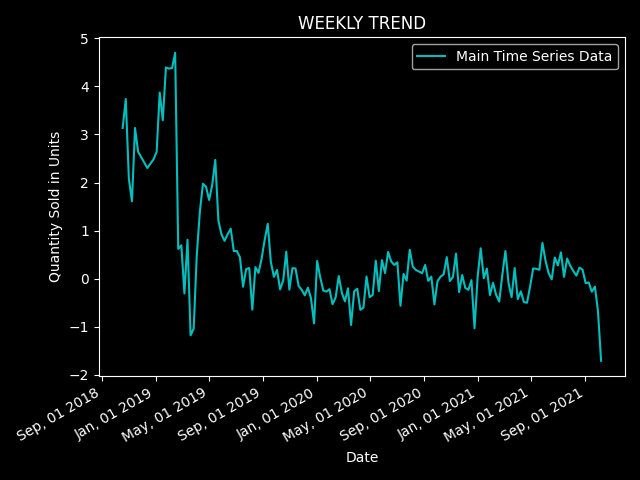

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
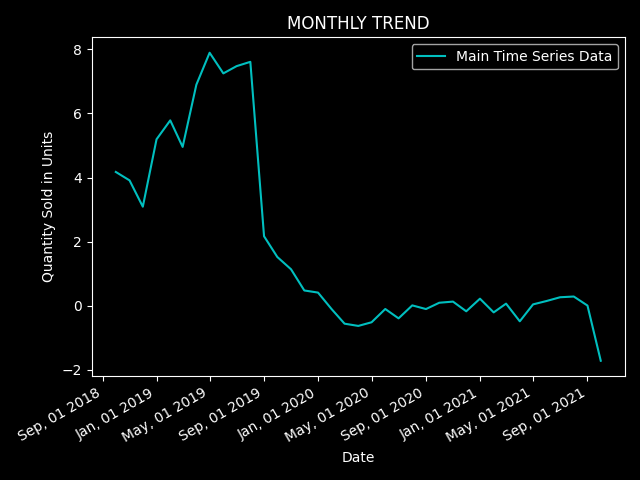

In [20]:
for freq in zip(freq_dict.keys(), windows):
    freq_dict[freq[0]]['roll_mean'] = rolling_window(freq_dict[freq[0]]['log'].values, freq[1], find_mean=True, find_std=False)
    freq_dict[freq[0]]['diff_rolling'] = freq_dict[freq[0]]['log'] - freq_dict[freq[0]]['roll_mean']

for col in ['roll_mean', 'diff_rolling']:
    for freq in zip(freq_dict.keys(), windows):
        plots(freq_dict[freq[0]]['Sale_Date'].values, freq_dict[freq[0]][col].values,
              f'{freq[0]} Trend'.upper(), freq[1])

WEEKLY Data is not Stationary. More Preprocessing Required
Results of Dickey Fuller Test for WEEKLY Data 
P-value       0.116685
#lags used    8.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
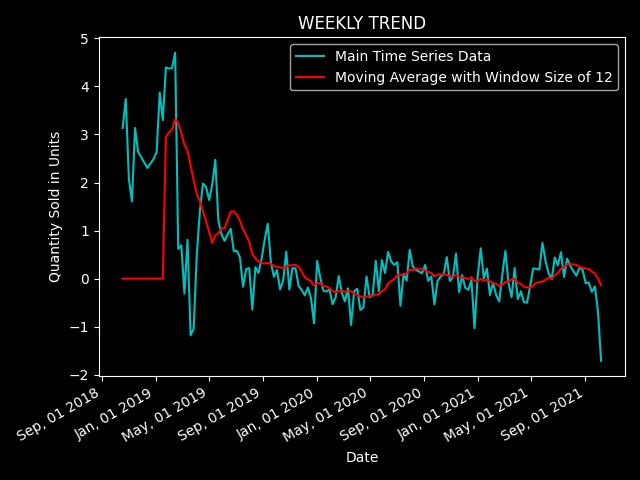

MONTHLY Data is not Stationary. More Preprocessing Required
Results of Dickey Fuller Test for MONTHLY Data 
P-value       0.741086
#lags used    1.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
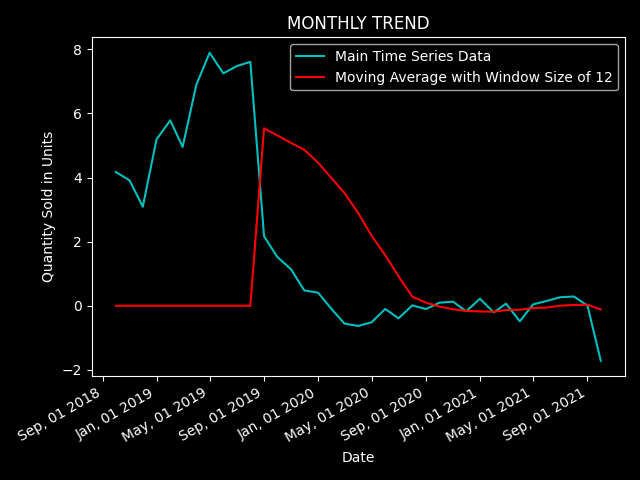

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
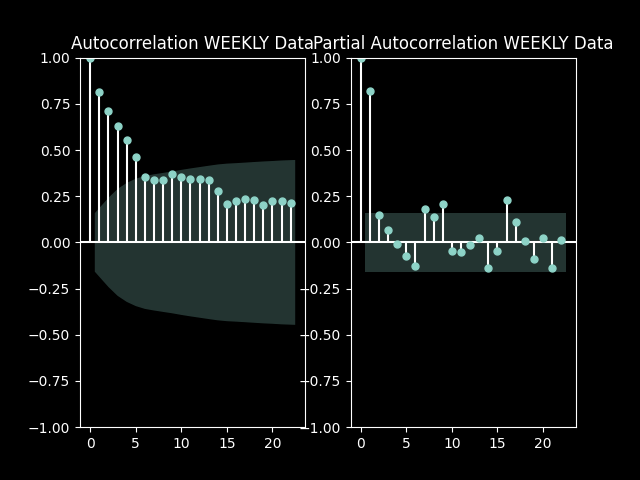

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
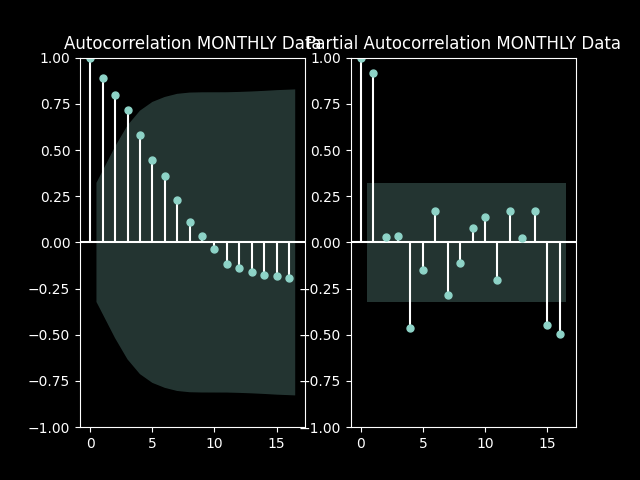

In [21]:
for freq in freq_dict.keys():
    stat_check(data=freq_dict[freq]['diff_rolling'].values, ts=freq.upper(), dates=freq_dict[freq]['Sale_Date'].values)

### **4. Subtracting Exponential Rolling Means**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
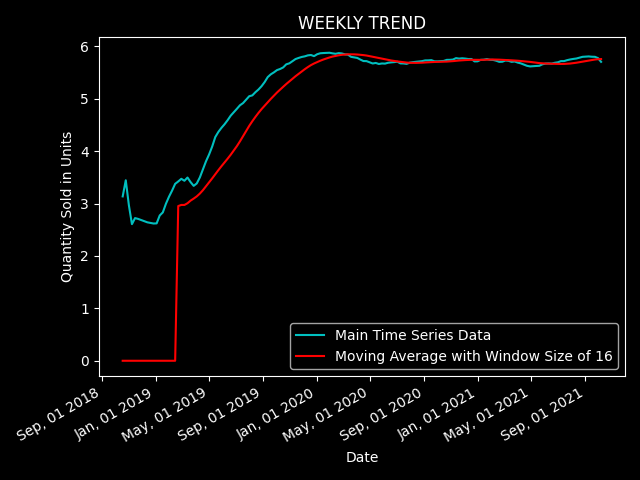

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
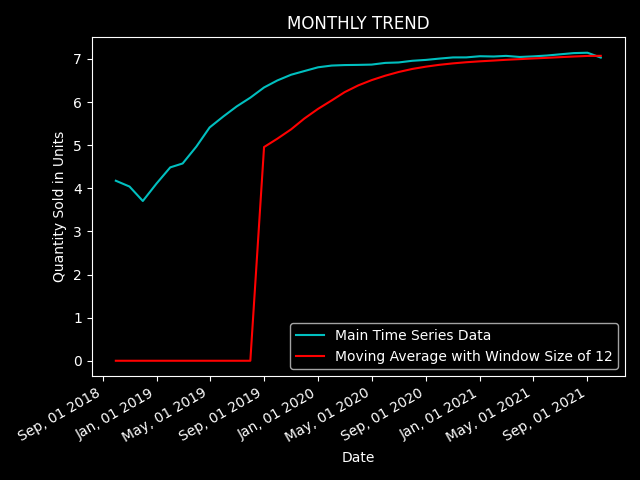

In [22]:
for freq in zip(freq_dict.keys(), windows):
    temp_df = pd.Series(freq_dict[freq[0]]['log'].values)
    freq_dict[freq[0]]['diff_ewm'] = temp_df.ewm(halflife = freq[1], min_periods=0, adjust=True).mean().values


for freq in zip(freq_dict.keys(), windows):
    plots(freq_dict[freq[0]]['Sale_Date'].values, freq_dict[freq[0]]['diff_ewm'].values,
          f'{freq[0]} Trend'.upper(), freq[1], mean=True, sav=False)

WEEKLY Data is Stationary. Proceed to Modelling
Results of Dickey Fuller Test for WEEKLY Data 
P-value       0.003158
#lags used    9.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
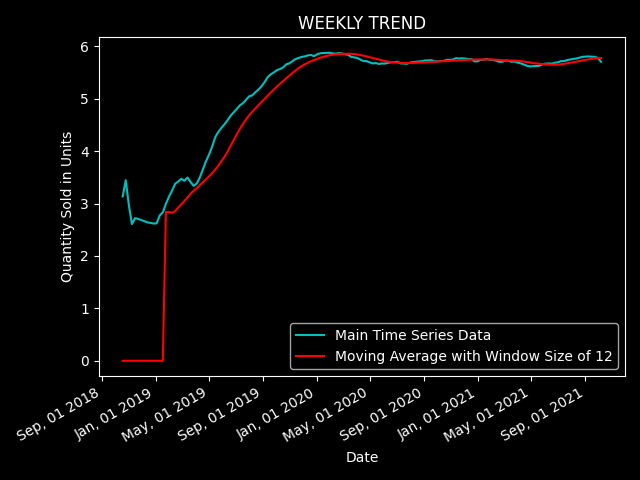

MONTHLY Data is not Stationary. More Preprocessing Required
Results of Dickey Fuller Test for MONTHLY Data 
P-value       0.079218
#lags used    0.000000
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
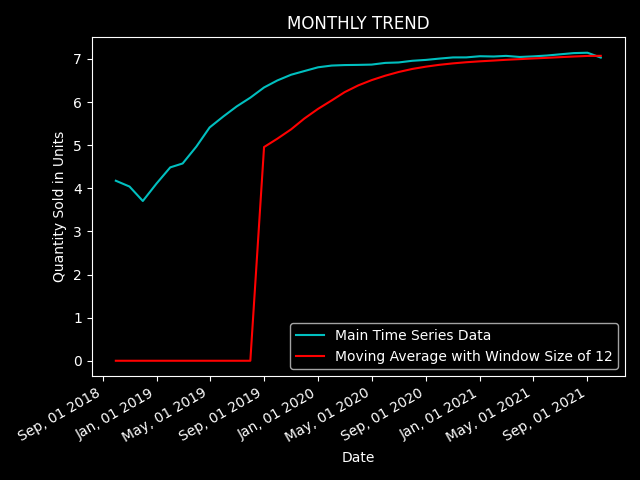

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
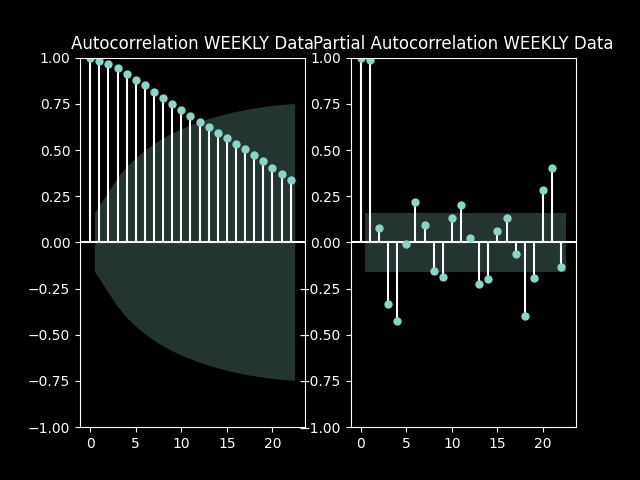

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
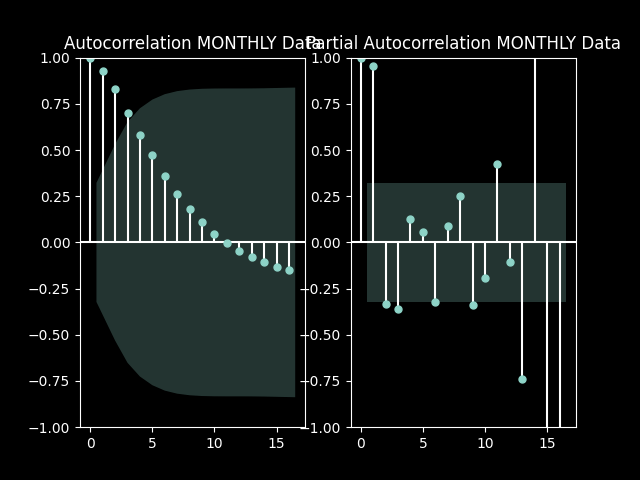

In [23]:
for freq in freq_dict.keys():
    stat_check(data=freq_dict[freq]['diff_ewm'].values, ts=freq.upper(), dates=freq_dict[freq]['Sale_Date'].values)

### **5. Differencing of the Dataset**

In [24]:
# Checking the best number of times differencing should be done
from pmdarima.arima.utils import ndiffs

## Adf Test
for freq in freq_dict.keys():
    print(freq, ndiffs(freq_dict[freq]['Quantity_In_Units'].values, test='adf'))

# KPSS test
for freq in freq_dict.keys():
    print(freq, ndiffs(freq_dict[freq]['Quantity_In_Units'].values, test='kpss'))

# PP test:
for freq in freq_dict.keys():
    print(freq, ndiffs(freq_dict[freq]['Quantity_In_Units'].values, test='pp'))


weekly 1
monthly 2
weekly 0
monthly 0
weekly 0
monthly 1


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
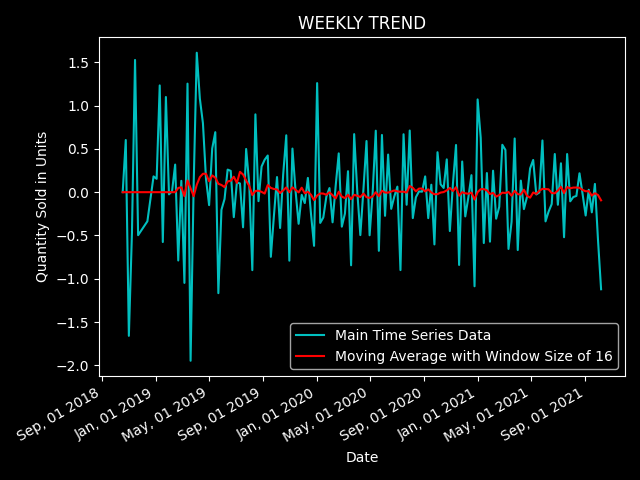

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
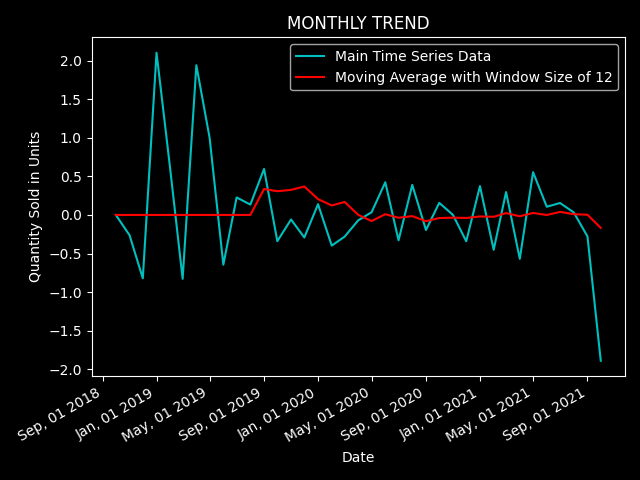

In [25]:
for freq in freq_dict.keys():
    temp_df = pd.Series(freq_dict[freq]['log'].values)
    freq_dict[freq]['diff_shift'] = np.nan_to_num(np.array(temp_df - temp_df.shift()), 0)

for freq in zip(freq_dict.keys(), windows):
    plots(freq_dict[freq[0]]['Sale_Date'].values, freq_dict[freq[0]]['diff_shift'].values,
          f'{freq[0]} Trend'.upper(), freq[1], mean=True, sav=False)

WEEKLY Data is Stationary. Proceed to Modelling
Results of Dickey Fuller Test for WEEKLY Data 
P-value       7.860456e-09
#lags used    7.000000e+00
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
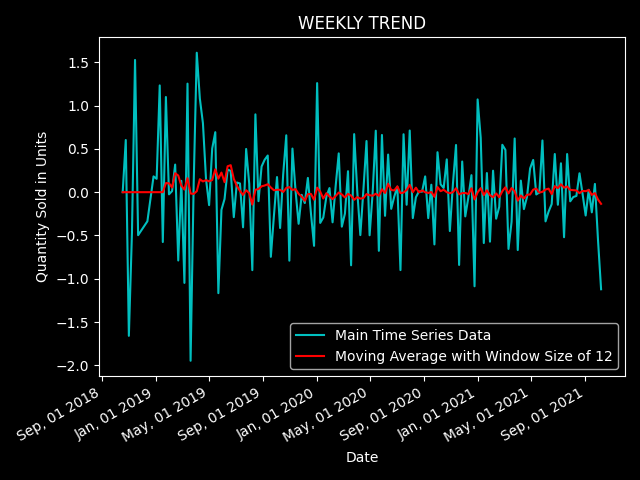

MONTHLY Data is Stationary. Proceed to Modelling
Results of Dickey Fuller Test for MONTHLY Data 
P-value       1.955467e-07
#lags used    0.000000e+00
dtype: float64


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
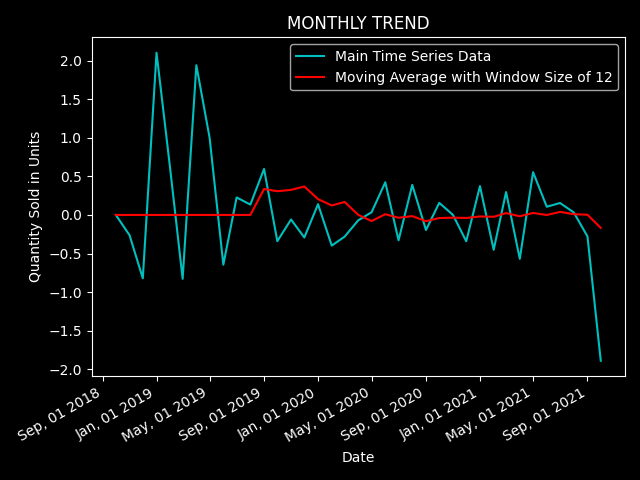

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
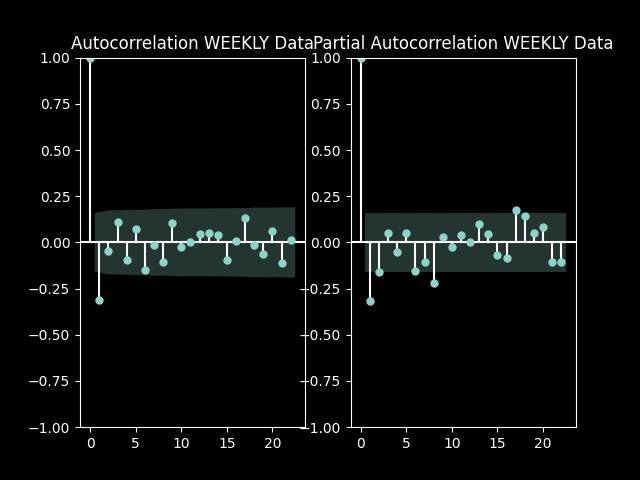

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
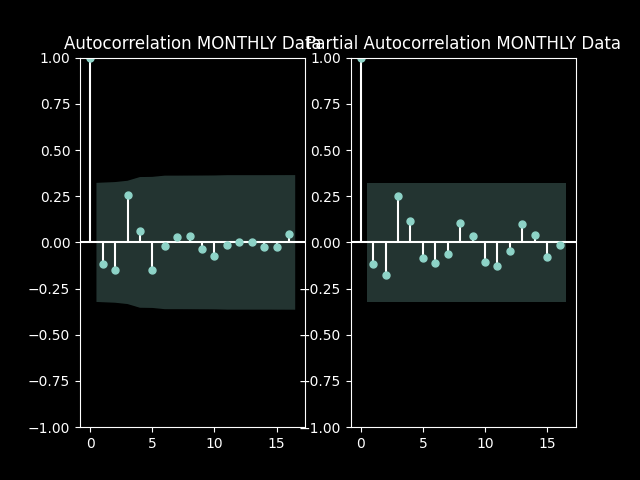

In [26]:
for freq in freq_dict.keys():
    stat_check(data=freq_dict[freq]['diff_shift'].values, ts=freq.upper(), dates=freq_dict[freq]['Sale_Date'].values)

### **MODELLING WITH ARIMA AND SARIMAX**

In [27]:
# You can determine the p and q lags using the plots however, i choose to use this automated approach and iterate
# through the possible combinations of lags i can get
bic_order = {}
for freq in freq_dict.keys():
    bic = arma_order_select_ic(freq_dict[freq].diff_shift.values)
    bic_order[freq] = bic['bic_min_order']

print(bic_order)

{'weekly': (0, 1), 'monthly': (0, 0)}


### **AUTO ARIMA**

In [28]:
# Splitting the dataset to Training (75%) and Test Set (25%)
def test_train(data, dates, train_size):
    df = pd.Series(data, index=dates)
    len_data = len(df)
    split_ix = round((train_size * len_data))
    train = df[:split_ix]
    test = df[split_ix:]
    print(f"{freq} Data has {len_data} rows split into Train: {len(train)} and Test: {len(test)} ")
    return (train, test)

validation = {}
for freq in freq_dict.keys():
    validation[freq] = test_train(freq_dict[freq]['Quantity_In_Units'].values, freq_dict[freq]['Sale_Date'].values, 0.75)

weekly Data has 153 rows split into Train: 115 and Test: 38 
monthly Data has 37 rows split into Train: 28 and Test: 9 


In [29]:
#Firstly lets try Auto Arima on the non-stationary data
def auto_arima(train, test, freq, weekly=False, monthly=False ):
    if weekly:
        m=4
    elif monthly:
        m=12
    else:
        m=1
    
    fitted = pm.auto_arima(y=train, start_p=0, start_q=0, start_d=0, test='adf', max_p=4,
                          max_q=4, m=m, d=None, seasonal=False, max_order=None,
                          trace=True,error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

    # Forecast
    train_rmse = mean_squared_error(train, fitted.predict_in_sample(n_periods=10), squared=False)
    fc, confint = fitted.predict(n_periods=len(test), return_conf_int=True)
    test_rmse = mean_squared_error(test, fc,  squared=False)
    

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=test.index)
    
    lower_series = pd.Series(confint[:,0], index=test.index)
    lower_series[lower_series[0:] < 0] = 0
    
    upper_series = pd.Series(confint[:, 1], index=test.index)
    

    print(f"Training RMSE: {train_rmse}")
    print(f"{freq} Data Best Parameters: {fitted.get_params()['order']}")
    # Plot
    fig = plt.figure()
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='w', alpha=.15)

    plt.title(f"Forecast of {freq} Data")
    plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1530.911, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1517.318, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1504.349, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1528.932, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1503.694, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1505.692, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1504.813, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1503.518, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1505.369, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1506.764, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1501.891, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1502.602, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1503.145, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1503.718, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]          

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
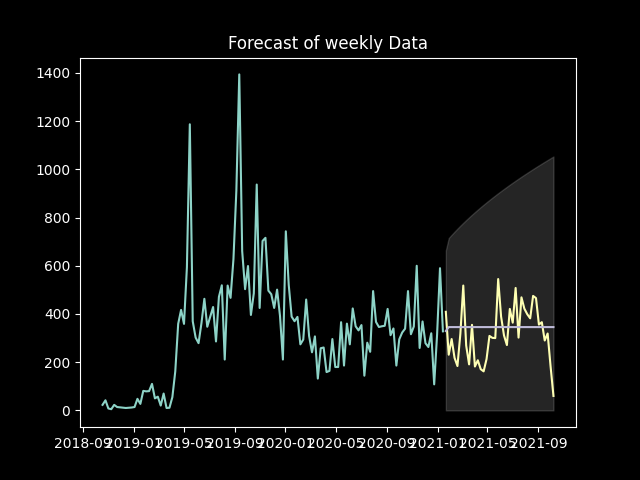

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=431.073, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=430.696, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=430.449, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.292, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=432.451, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.113 seconds
Training RMSE: 649.2799308244701
monthly Data Best Parameters: (0, 1, 0)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
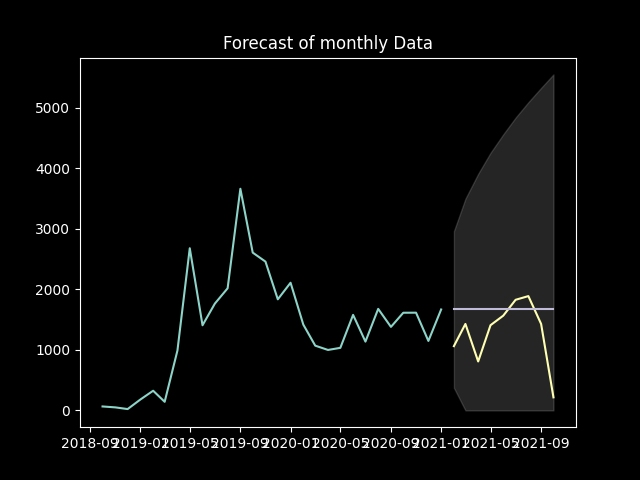

In [30]:
for key in validation.keys():
    auto_arima(validation[key][0], validation[key][1], weekly=True, freq=key)

In [31]:
# function to run our model
def run_arima_model(df, p, d, q, freq, plot=True):
    """
    Run ARIMA model
    """
    # fit ARIMA model on time series
    model = ARIMA(df, order=(p, d, q))  
    model_fit = model.fit()  

    # get lengths correct to calculate RSS
    len_results = len(model_fit.fittedvalues)
    ts_modified = df[-len_results:]

    # calculate root mean square error (RMSE) and residual sum of squares (RSS)
    rss = sum((model_fit.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(df))
    
    if plot:
        fig = plt.figure()
        plt.plot(df)
        plt.plot(model_fit.fittedvalues, color = 'red')
        plt.title('ARIMA model (%i, %i, %i) for RSS: %.4f, RMSE: %.4f %s' %(p, d, q, rss, rmse, freq))
        plt.show()  
    
    return model_fit , rmse

# function to run our model
def run_sarimax_model(df, p, d, q, s, freq, plot=False):
    """
    Run SARIMAX model
    """
    #assign the date to the index of the dataset
    
    # fit SARIMAX model on time series
    model = SARIMAX(df, order=(p, d, q), seasonal_order = (p,d,q,s))  
    results_ = model.fit()  

    # get lengths correct to calculate RSS
    len_results = len(results_.fittedvalues)
    ts_modified = df[-len_results:]

    # calculate root mean square error (RMSE) and residual sum of squares (RSS)
    rss = sum((results_.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(df))

    if plot:
        fig = plt.figure()
        plt.plot(df)
        plt.plot(results_.fittedvalues, color = 'red')
        plt.title('SARIMAX model (%i, %i, %i) for RSS: %.4f, RMSE: %.4f %s' %(p, d, q, rss, rmse, freq))
        plt.show()  
    return results_ , rmse

In [32]:
validation = {}
for freq in freq_dict.keys():
    validation[freq] = test_train(freq_dict[freq]['diff_shift'].values, freq_dict[freq]['Sale_Date'].values, 0.75)

weekly Data has 153 rows split into Train: 115 and Test: 38 
monthly Data has 37 rows split into Train: 28 and Test: 9 


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
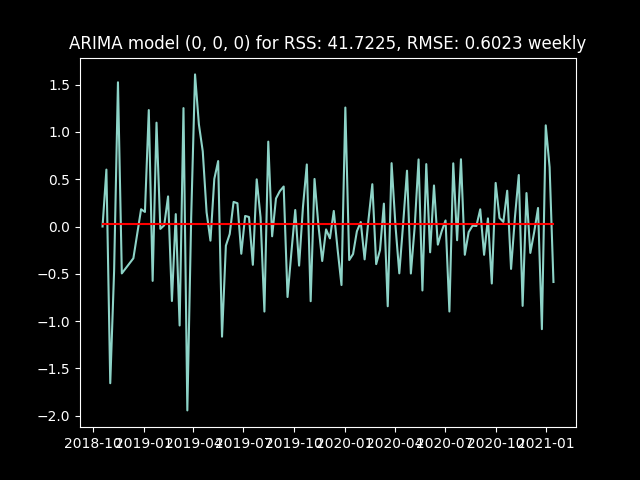

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
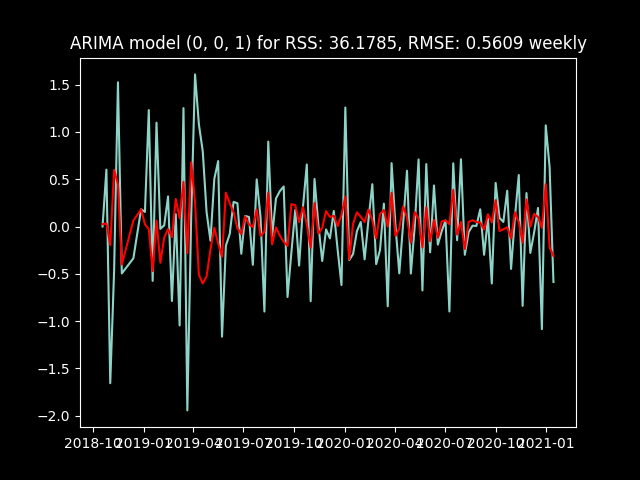

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
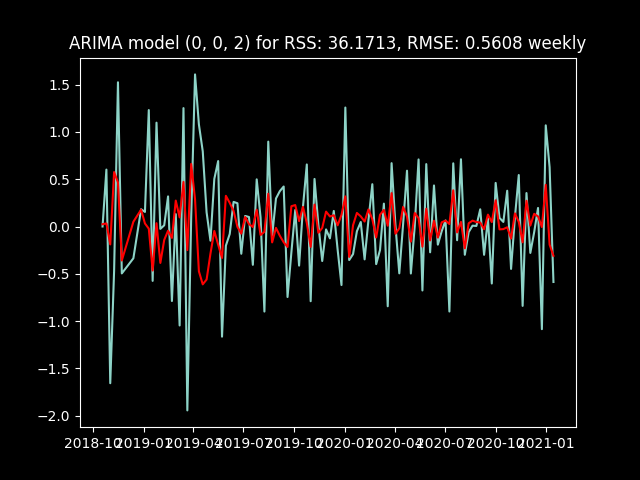

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
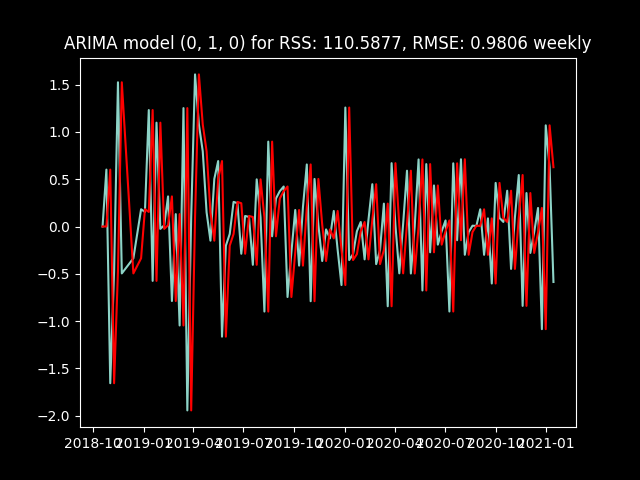

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
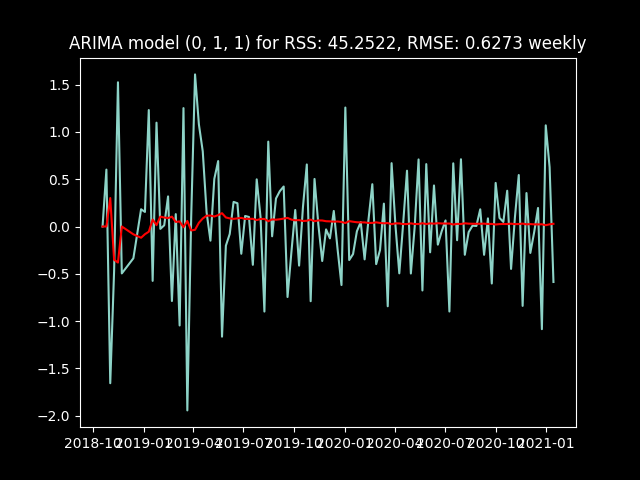

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
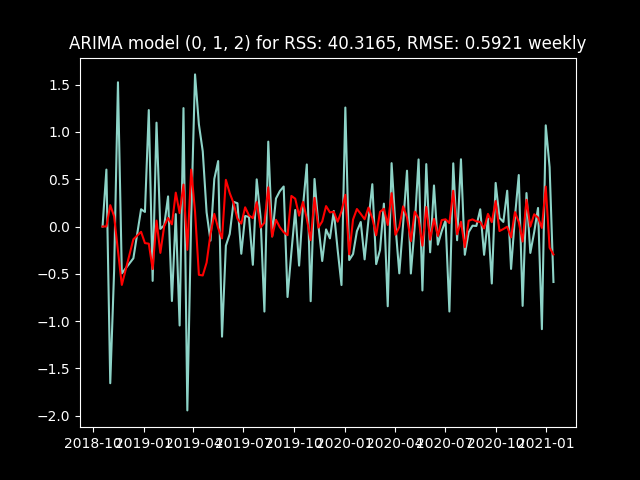

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
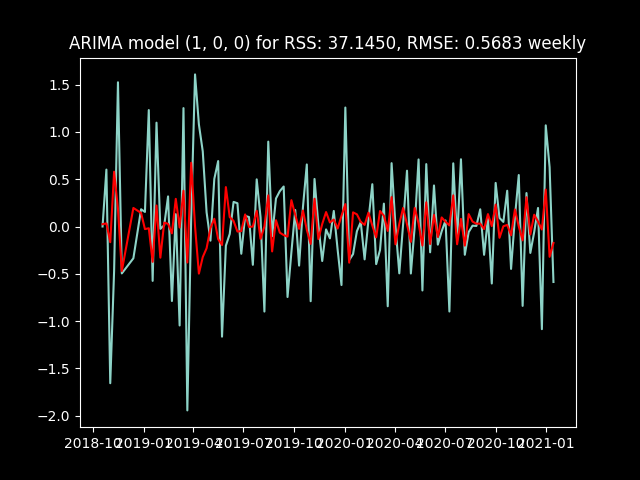

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
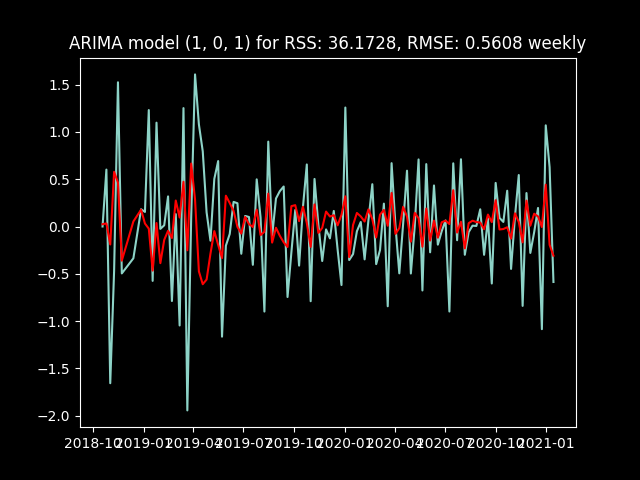

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
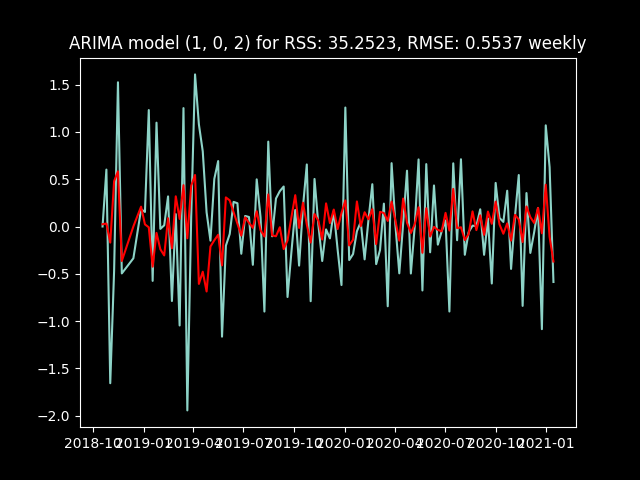

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
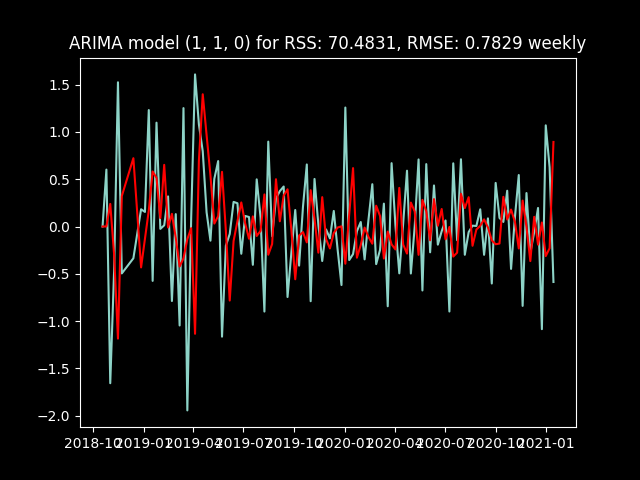

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
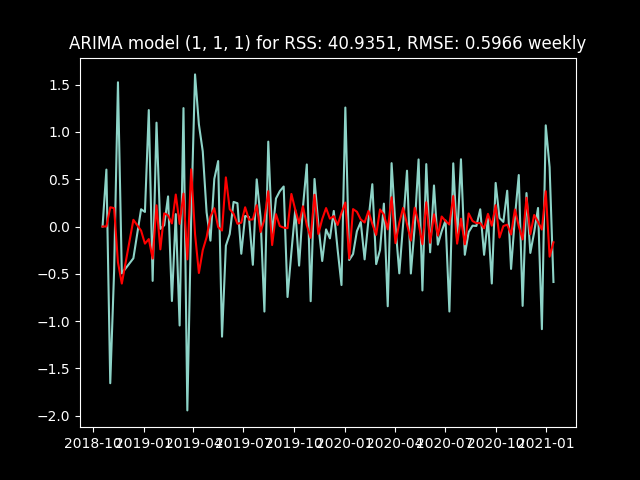

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
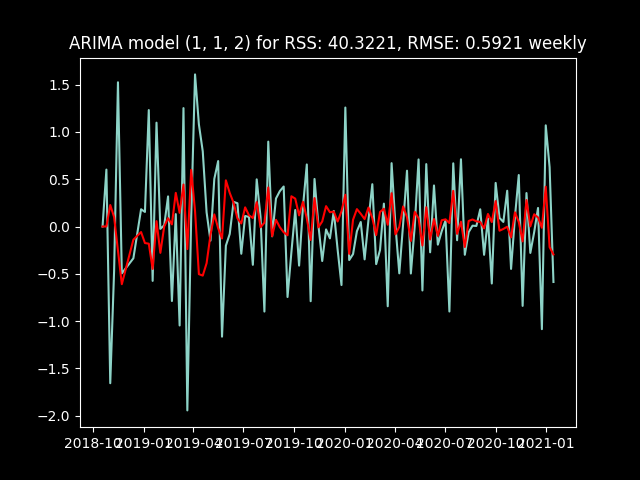

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
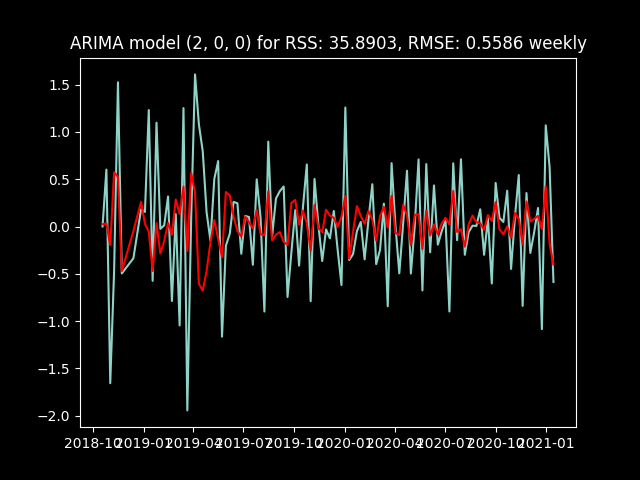

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
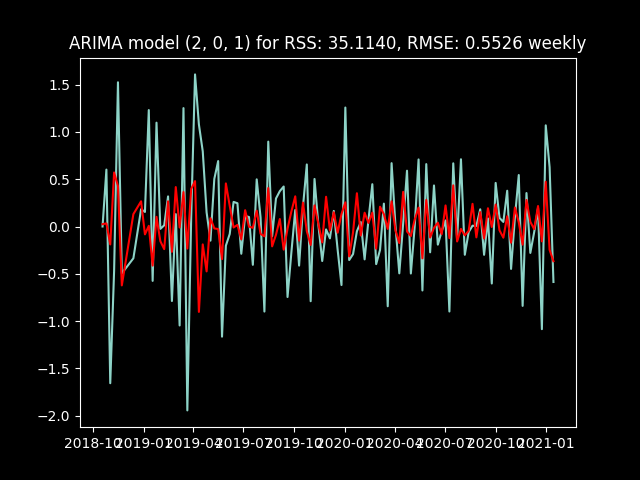

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
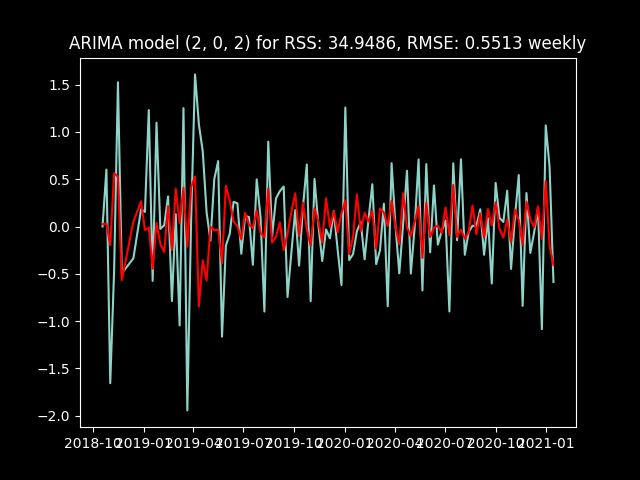

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
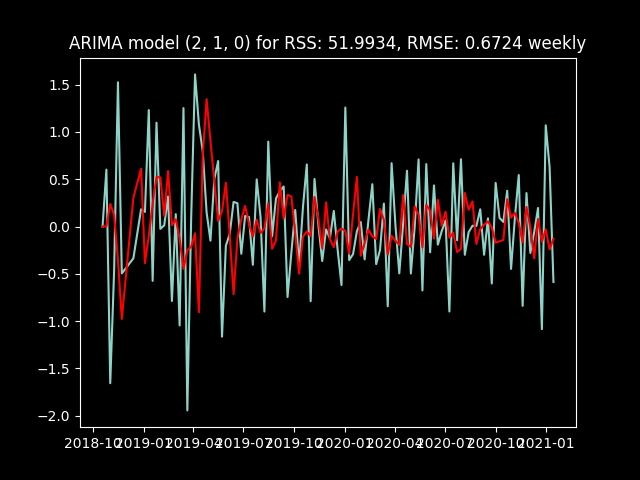

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
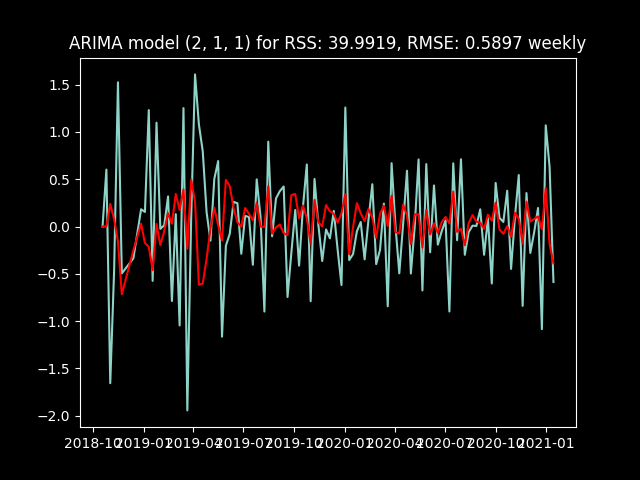

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
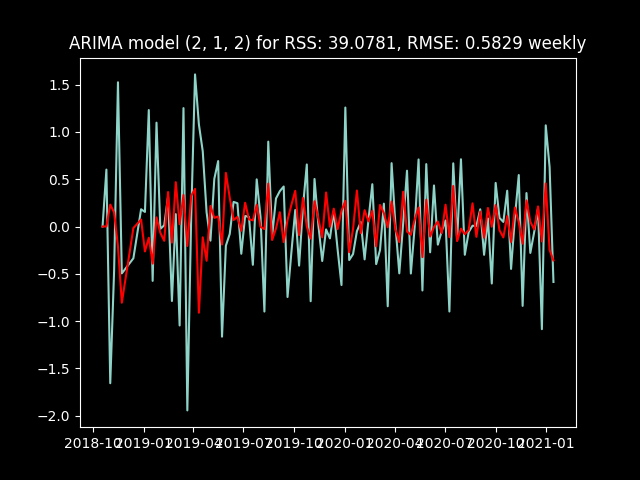

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
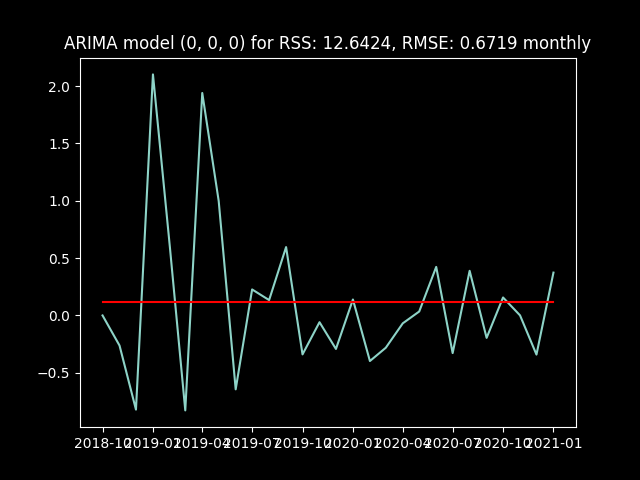

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
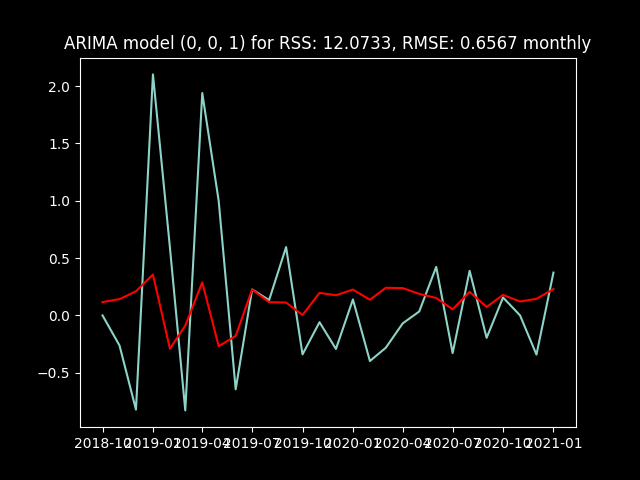

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
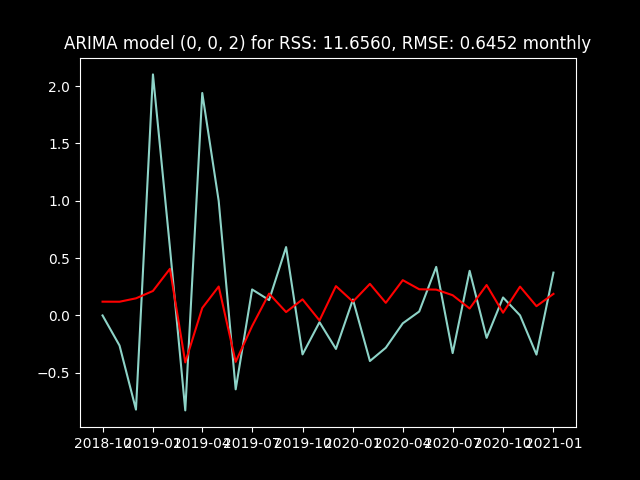

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
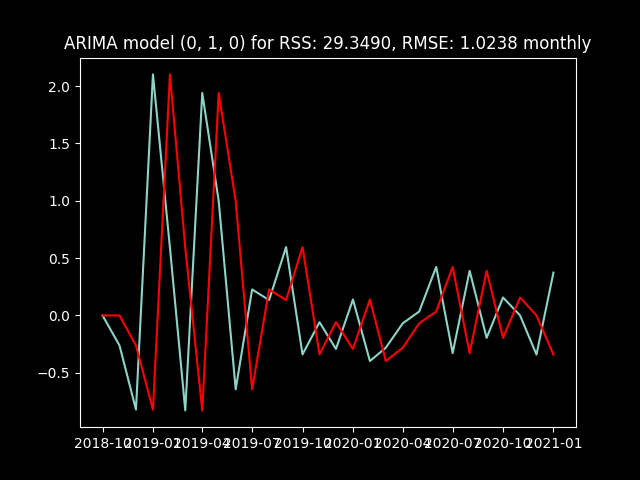

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
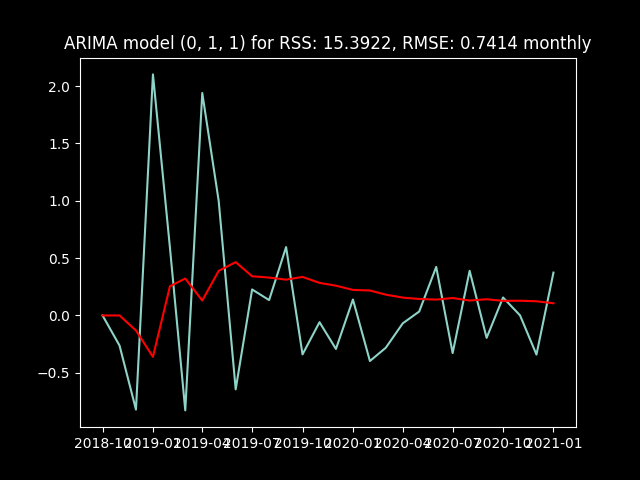

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
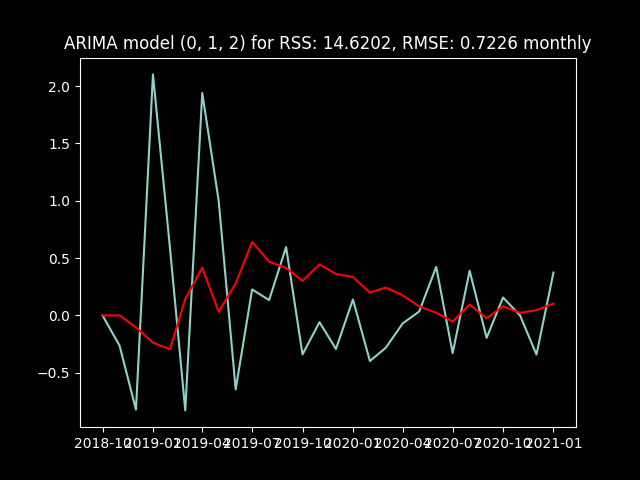

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
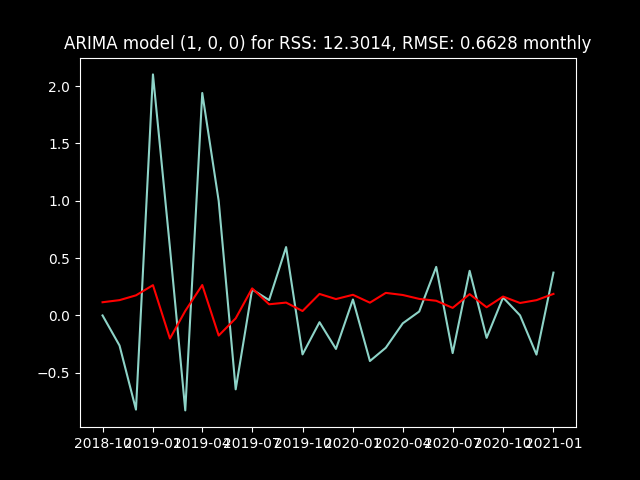

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
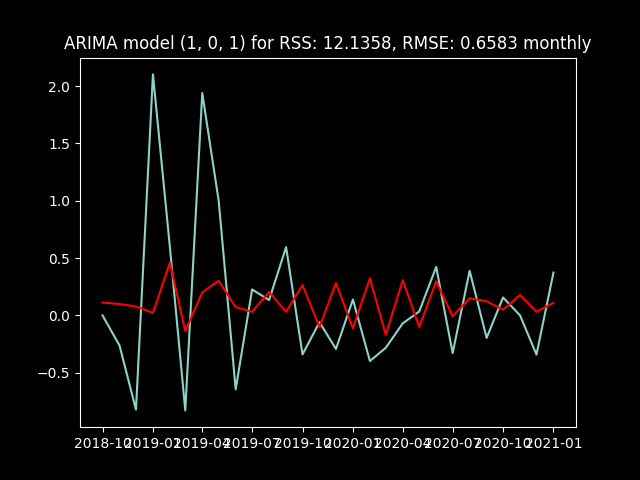

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
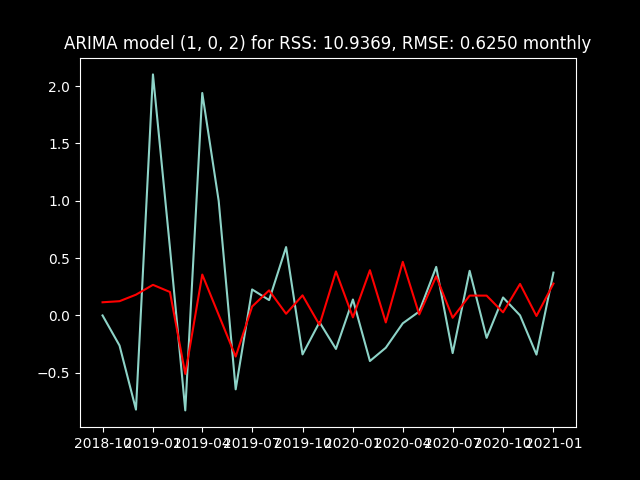

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
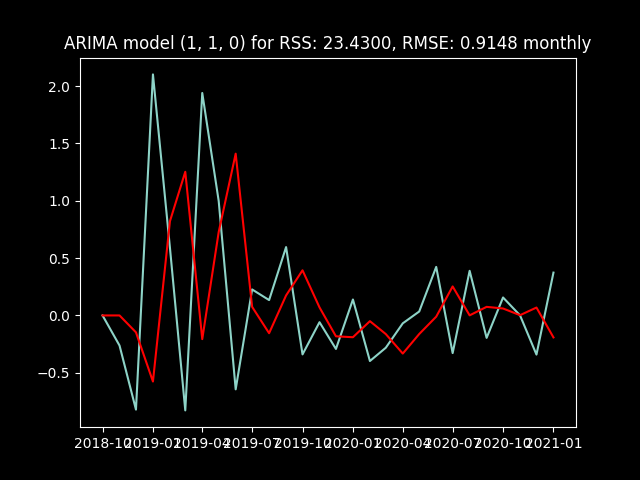

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
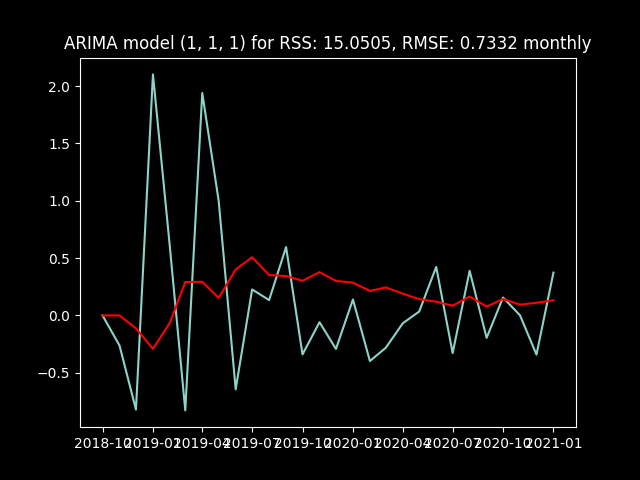

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
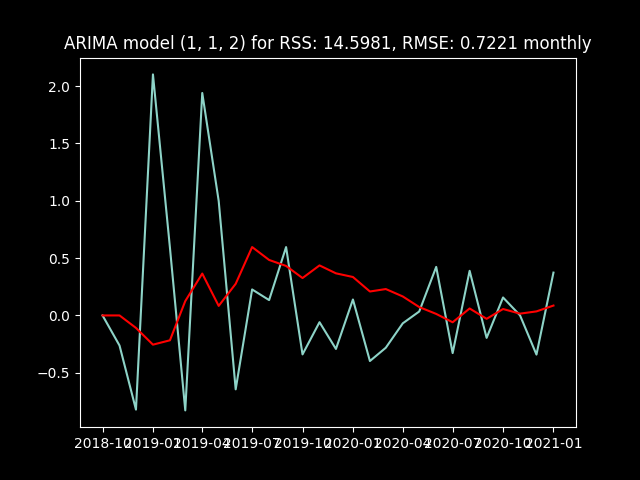

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
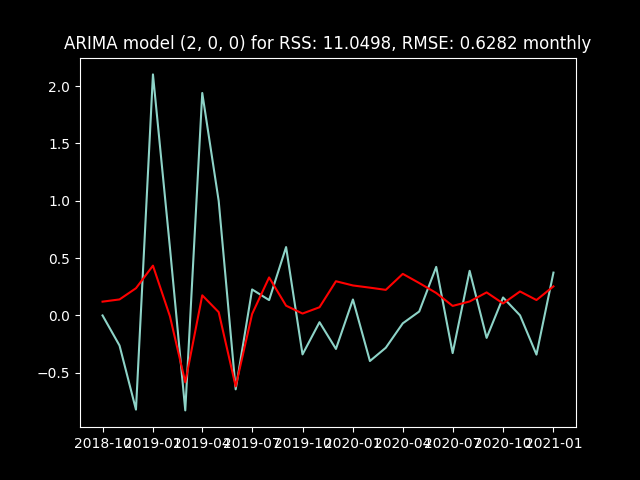

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
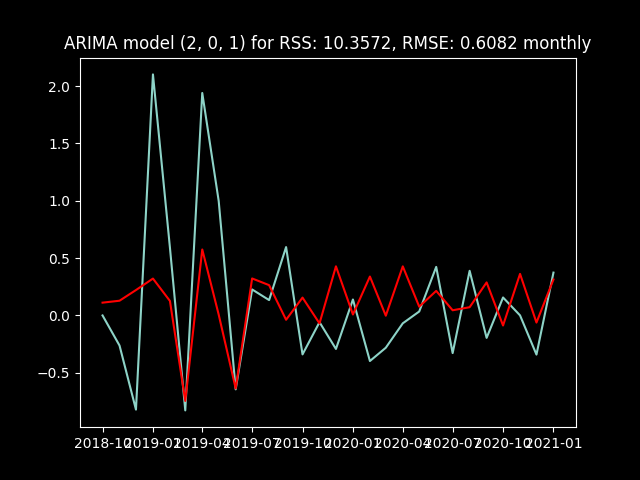

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
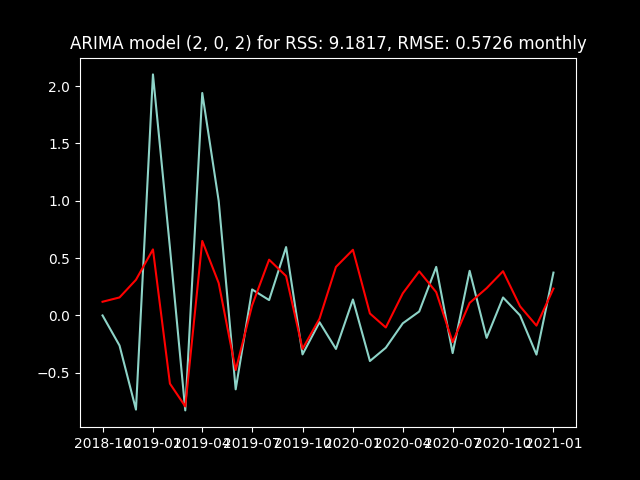

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
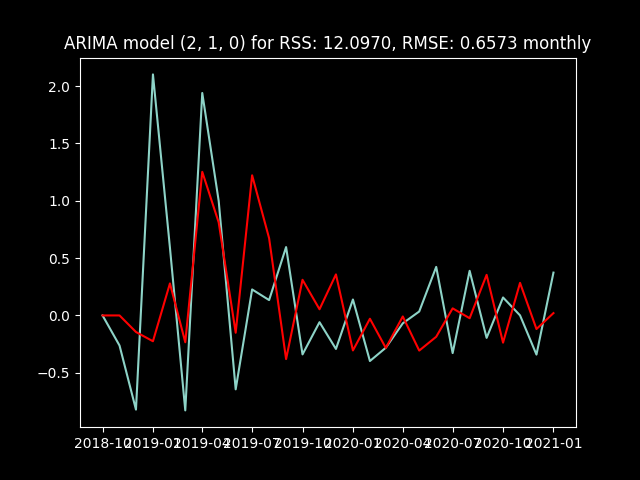

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
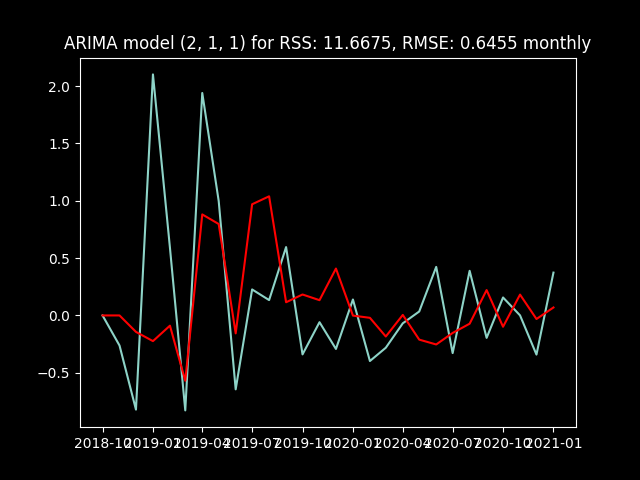

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
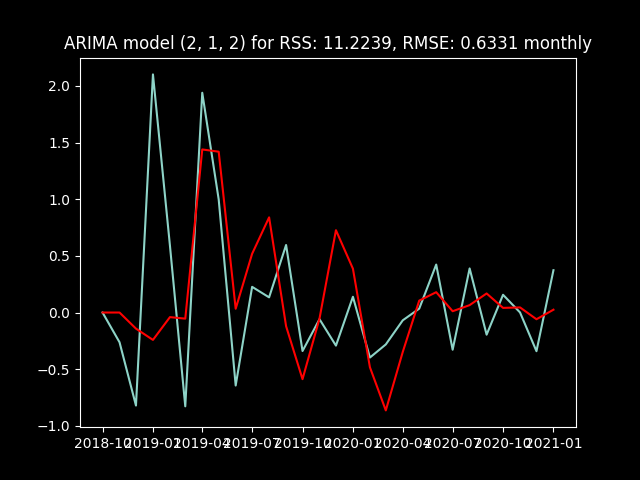

In [33]:
arima_dict = {}
model_list = []

for freq in validation.keys():
    for p in [0,1,2]:
        for d in [0,1]:
            for q in [0,1,2]:
                model_AR = run_arima_model(df=validation[freq][0],p=p, d=d, q=q, freq=freq)
                if model_list == []:
                    model_list.append(model_AR)
                else:
                    if model_list[0][1] > model_AR[1]:
                        model_list[0] = model_AR
    arima_dict[freq] = model_list[0]
    model_list = []
            

In [34]:
sarimax_dict = {}
model_list = []

for freq in zip(validation.keys(), windows):
    for p in [0,1,2]:
        for d in [0,1]:
            for q in [0,1,2]:
                model_sa = run_sarimax_model(df=validation[freq[0]][0], p=p, d=d, q=q,s=freq[1], freq=freq[0])
                if model_list == []:
                    model_list.append(model_sa)
                else:
                    if model_list[0][1] > model_sa[1]:
                        model_list[0] = model_sa
    sarimax_dict[freq[0]] = model_list[0]
    model_list = []
            

### Predictions with Arima 


In [35]:
def transform(predictions, log):
    exp = np.exp(predictions.cumsum()) + np.exp(log)
    exp = exp.dropna()
    return exp

In [36]:
def predictions(model, train, test, log_data, freq):
    pred = model.forecast(steps=len(test))
    pred.index = test.index
    fc = transform(pred, log_data)
    tn = transform(train, log_data)
    tt = transform(test, log_data)
    
    rmse = mean_squared_error(pred, test, squared=False)
    print(f"RMSE: {rmse}")
    
    fig = plt.figure(dpi=100)
    plt.plot(tn, label='training')
    plt.plot(tt, label='actual')
    plt.plot(fc, label='forecast')
#     plt.fill_between(lower_series.index, lower_series, upper_series, 
#                      color='w', alpha=0.1)
    plt.title(f'Forecast vs Actuals ({freq.upper()} Data)')
    plt.legend(loc='best', fontsize=10)
    plt.show()
    
        


RMSE: 0.3862250299694719


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
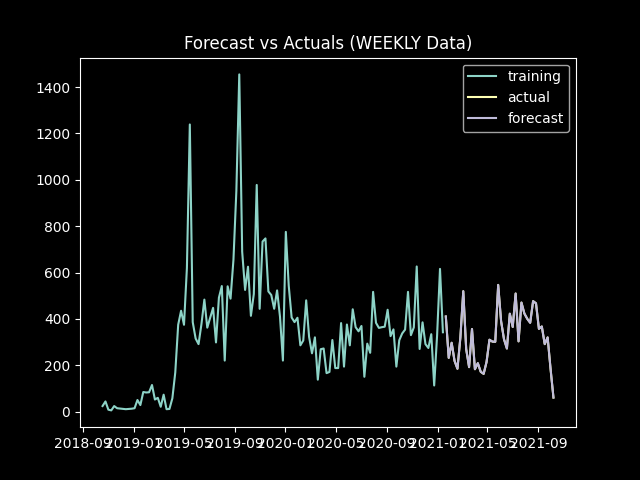

RMSE: 0.8243538420946901


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
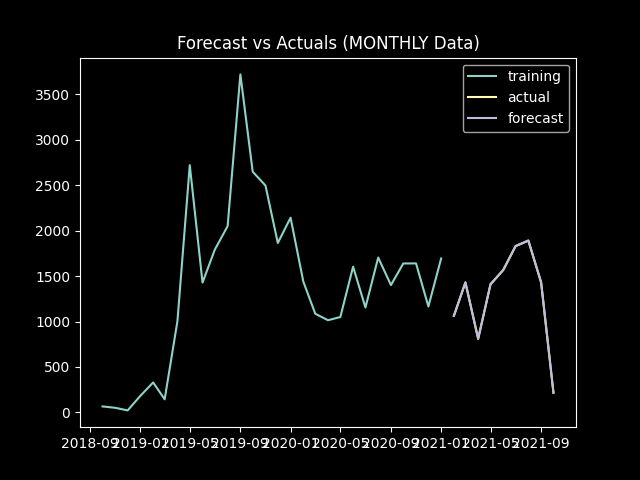

In [37]:
for key in freq_dict.keys():
    log_data = pd.Series(freq_dict[key]['log'].values, index=freq_dict[key]['Sale_Date'].values)
    predictions(sarimax_dict[key][0], validation[key][0], validation[key][1], log_data, key)

### **LSTM**

In [38]:
# Create two dataframes for  weekly and monthly analysis only to prevent use of the dictionary
weekly = freq_dict['weekly'][['Sale_Date', 'Quantity_In_Units']]
monthly = freq_dict['monthly'][['Sale_Date', 'Quantity_In_Units']]

In [39]:
# Preparing with Monthly Data Only
# univariate data preparation
# split a univariate sequence into samples
def split(arr, n_steps):
	X, y = list(), list()
	for i in range(len(arr)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(arr)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = arr[i:end_ix], arr[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
X, y = split(monthly['Quantity_In_Units'].values, 3)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[65. 50. 22.] 180.0
[ 50.  22. 180.] 325.0
[ 22. 180. 325.] 142.0
[180. 325. 142.] 988.0
[325. 142. 988.] 2680.0
[ 142.  988. 2680.] 1407.0
[ 988. 2680. 1407.] 1765.0
[2680. 1407. 1765.] 2018.0
[1407. 1765. 2018.] 3663.0
[1765. 2018. 3663.] 2608.0
[2018. 3663. 2608.] 2459.0
[3663. 2608. 2459.] 1836.0
[2608. 2459. 1836.] 2110.0
[2459. 1836. 2110.] 1418.0
[1836. 2110. 1418.] 1070.0
[2110. 1418. 1070.] 999.0
[1418. 1070.  999.] 1034.0
[1070.  999. 1034.] 1579.0
[ 999. 1034. 1579.] 1137.0
[1034. 1579. 1137.] 1678.0
[1579. 1137. 1678.] 1380.0
[1137. 1678. 1380.] 1614.0
[1678. 1380. 1614.] 1615.0
[1380. 1614. 1615.] 1148.0
[1614. 1615. 1148.] 1668.0
[1615. 1148. 1668.] 1062.0
[1148. 1668. 1062.] 1429.0
[1668. 1062. 1429.] 809.0
[1062. 1429.  809.] 1408.0
[1429.  809. 1408.] 1566.0
[ 809. 1408. 1566.] 1828.0
[1408. 1566. 1828.] 1889.0
[1566. 1828. 1889.] 1429.0
[1828. 1889. 1429.] 216.0


In [40]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

#### One Layer LSTM

In [43]:
n_steps = 3
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=2)


Epoch 1/200
2/2 - 1s - loss: 2071453.1250 - 981ms/epoch - 490ms/step
Epoch 2/200
2/2 - 0s - loss: 1963889.6250 - 7ms/epoch - 3ms/step
Epoch 3/200
2/2 - 0s - loss: 1834195.8750 - 4ms/epoch - 2ms/step
Epoch 4/200
2/2 - 0s - loss: 1750124.1250 - 9ms/epoch - 4ms/step
Epoch 5/200
2/2 - 0s - loss: 1651916.5000 - 5ms/epoch - 2ms/step
Epoch 6/200
2/2 - 0s - loss: 1570266.8750 - 10ms/epoch - 5ms/step
Epoch 7/200
2/2 - 0s - loss: 1456602.8750 - 5ms/epoch - 2ms/step
Epoch 8/200
2/2 - 0s - loss: 1362144.7500 - 11ms/epoch - 5ms/step
Epoch 9/200
2/2 - 0s - loss: 1278139.3750 - 5ms/epoch - 2ms/step
Epoch 10/200
2/2 - 0s - loss: 1184563.7500 - 13ms/epoch - 6ms/step
Epoch 11/200
2/2 - 0s - loss: 1109464.0000 - 9ms/epoch - 4ms/step
Epoch 12/200
2/2 - 0s - loss: 1034156.1250 - 5ms/epoch - 2ms/step
Epoch 13/200
2/2 - 0s - loss: 969330.1250 - 11ms/epoch - 5ms/step
Epoch 14/200
2/2 - 0s - loss: 904060.5000 - 5ms/epoch - 2ms/step
Epoch 15/200
2/2 - 0s - loss: 833643.5000 - 10ms/epoch - 5ms/step
Epoch 16/200


2/2 - 0s - loss: 330538.2812 - 8ms/epoch - 4ms/step
Epoch 127/200
2/2 - 0s - loss: 330686.1875 - 3ms/epoch - 2ms/step
Epoch 128/200
2/2 - 0s - loss: 313568.2812 - 11ms/epoch - 6ms/step
Epoch 129/200
2/2 - 0s - loss: 308178.2500 - 5ms/epoch - 2ms/step
Epoch 130/200
2/2 - 0s - loss: 309790.8750 - 8ms/epoch - 4ms/step
Epoch 131/200
2/2 - 0s - loss: 272631.6562 - 4ms/epoch - 2ms/step
Epoch 132/200
2/2 - 0s - loss: 255048.5938 - 4ms/epoch - 2ms/step
Epoch 133/200
2/2 - 0s - loss: 258575.8750 - 7ms/epoch - 3ms/step
Epoch 134/200
2/2 - 0s - loss: 260354.1406 - 4ms/epoch - 2ms/step
Epoch 135/200
2/2 - 0s - loss: 272445.9375 - 7ms/epoch - 3ms/step
Epoch 136/200
2/2 - 0s - loss: 299036.7500 - 4ms/epoch - 2ms/step
Epoch 137/200
2/2 - 0s - loss: 301182.1875 - 5ms/epoch - 2ms/step
Epoch 138/200
2/2 - 0s - loss: 369160.3125 - 4ms/epoch - 2ms/step
Epoch 139/200
2/2 - 0s - loss: 425083.9688 - 5ms/epoch - 2ms/step
Epoch 140/200
2/2 - 0s - loss: 445949.2500 - 6ms/epoch - 3ms/step
Epoch 141/200
2/2 - 0s 

In [45]:
# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[301.9604]]
